In [363]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import pandas as pd
import datetime as dt

from scipy import stats
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
%matplotlib inline
import calendar

## Читаем данные

In [364]:
df=pd.read_pickle('MG_Sales.pickle',compression='gzip')

## Обучение с помощью прорицателя фейсбука

In [365]:
#Праздники
changepoints=df[df['Праздник']==1]['Дата'].unique()
selebrate=pd.DataFrame({
    'holiday': 'playoff',
    'ds': changepoints,
    'lower_window': -5,
    'upper_window': 1,
    })

#Формируем выборку
time_series=pd.DataFrame(data=df[(df['ЦветМеталла']=='Красное золото')&(df['Дата']>=dt.date(2013,1,1))].groupby('Дата')['Количество'].sum())
time_series.index.name='ds'
time_series.columns=['y']
time_series['y'] = np.log(time_series['y'])

## Удаляем выбросы

In [366]:
lim=0.7
ulim=np.percentile(time_series['y'], 100.-lim)
llim=np.percentile(time_series['y'], lim)

time_series.loc[time_series.y<llim]=None
time_series.loc[time_series.y>ulim]=None

## Обучение выборки с кросс-валидацией

In [367]:
folds=3
changepoint_prior_scale=0.003

#начинаем с последнего месяца
last=time_series.iloc[-1].name
startDt=dt.datetime(last.year,last.month,last.day)
lastDay=dt.datetime(last.year,last.month,1)-dt.timedelta(seconds=1)
startmonth=dt.datetime(lastDay.year,lastDay.month,1)

#готовим период деления валидации
pediods=[]
for i in range(folds):
    pediods.append([startmonth,startDt])    
    startDt=startmonth-dt.timedelta(seconds=1)
    startmonth=dt.datetime(startDt.year,startDt.month,1)

#changepoint_prior_scale - гиперпараметр процента точек смены тренда (по-умолчанию: 0.05)
#changepoints  - массив для ручной установки дат смены тренда
#interval_width - предсказательный интервал
#mcmc_samples - количество шагов для расчета неопределенности в сезонности для байесовской модели
#holidays - датасет с праздникам

#параметр роста
time_series['cap'] = 150

    
mape=[]
mae=[]
#делим выборку на обучающую и валидационную
for begin,end in reversed(pediods):
    date_div_past=begin-dt.timedelta(days=1)

    time_series_train=time_series.loc[:date_div_past]
    time_series_test=time_series.loc[begin:end]

    m = Prophet(holidays = selebrate, growth = 'logistic', changepoint_prior_scale=changepoint_prior_scale,yearly_seasonality=True)#,mcmc_samples=75
    #обучение
    m.fit(time_series_train.reset_index())
    
    #Подготовка календаря будущего
    future = time_series_test.reset_index()

    #Предсказание
    forecast = m.predict(future)
    
    cmp_df = np.exp(forecast.set_index('ds')[['yhat']].join(time_series_test))
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
    mape.append(round(np.mean(abs(cmp_df['p'])),2))
    mae.append(round(np.mean(abs(cmp_df['e'])),2))
    
        
print ('Качество модели (%), чем выше тем лучше: ', 100-np.mean(mape))
print ('Абсолютное значение ошибки, чем ниже тем лучше: ', np.mean(mae))

Качество модели (%), чем выше тем лучше:  75.2766666667
Абсолютное значение ошибки, чем ниже тем лучше:  50.1433333333


## Отрисовка от прорицателя

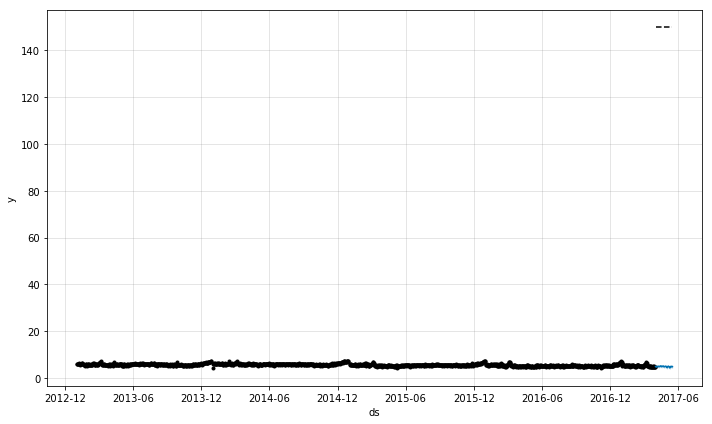

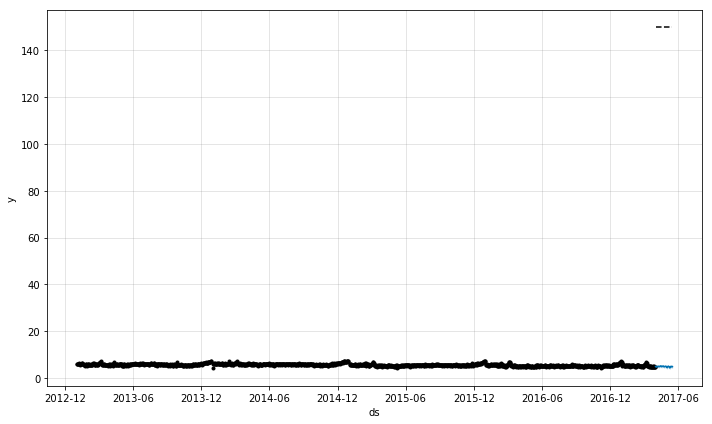

In [368]:
m.plot(forecast)

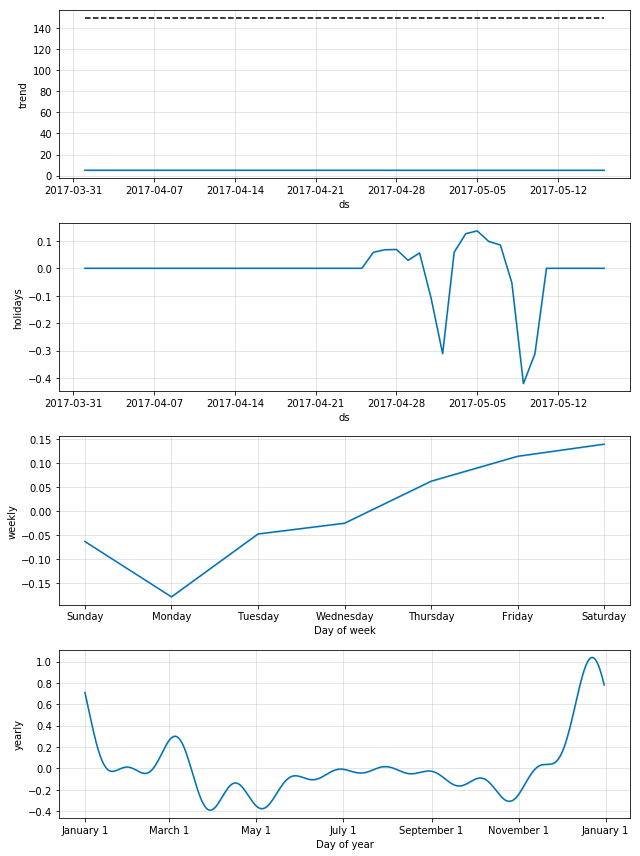

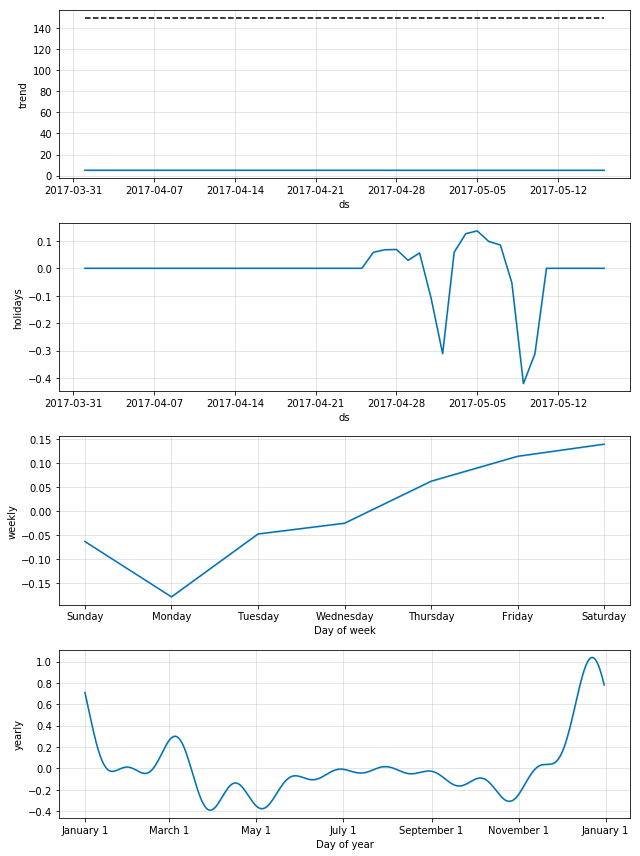

In [369]:
m.plot_components(forecast)

## График прогноза и реальных значений

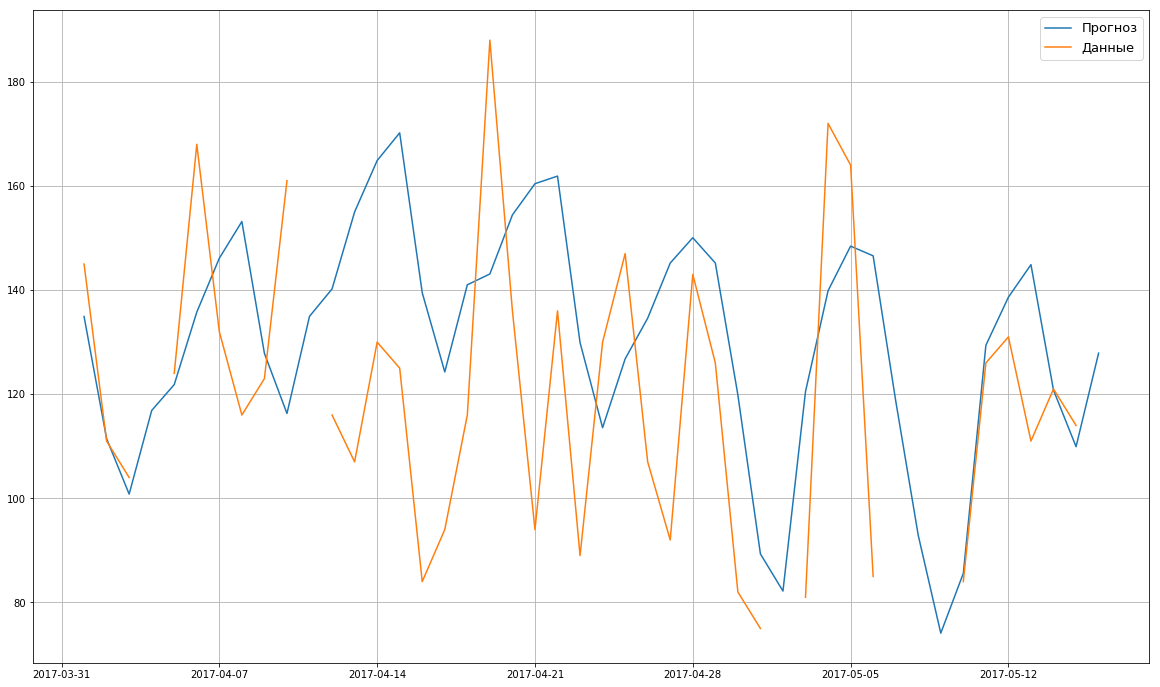

In [370]:
plt.figure(figsize=(20,12))
plt.plot(cmp_df.yhat, label = "Прогноз")
plt.plot(cmp_df.y, label = "Данные")
#plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);